In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Part 1 - Exploratory data analysis

## Load data

In [2]:
df = pd.read_json('logins.json')

In [3]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## Check data contents: data type is datetime64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


## Check NaN values: there is no NaN value

In [5]:
df.isnull().any()

login_time    False
dtype: bool

## Time series data is not ordered correctly: need to sort

In [6]:
df = df.set_index('login_time').sort_index()
df['count'] = 1
df.head()

,count
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1


In [7]:
df.tail()

,count
login_time,
1970-04-13 18:48:52,1
1970-04-13 18:50:19,1
1970-04-13 18:54:02,1
1970-04-13 18:54:23,1
1970-04-13 18:57:38,1


In [8]:
df = df.resample('15T').sum()

In [9]:
df.resample('M').sum()

,count
login_time,
1970-01-31,21239
1970-02-28,24673
1970-03-31,33723
1970-04-30,13507


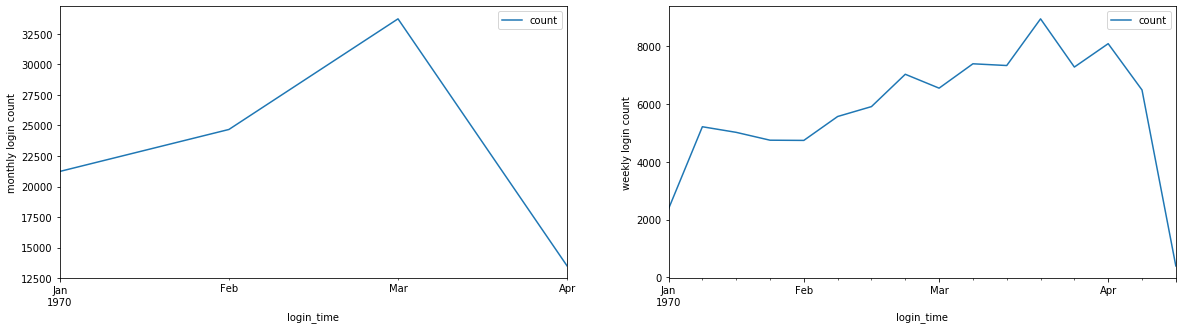

In [10]:
monthly = df.resample('M').sum()
weekly = df.resample('W').sum()

fig, axes = plt.subplots(1,2, figsize=(20, 5))
monthly.plot(ax=axes[0])
axes[0].set_xlabel('login_time')
axes[0].set_ylabel('monthly login count')
weekly.plot(ax=axes[1])
axes[1].set_xlabel('login_time')
_= axes[1].set_ylabel('weekly login count')

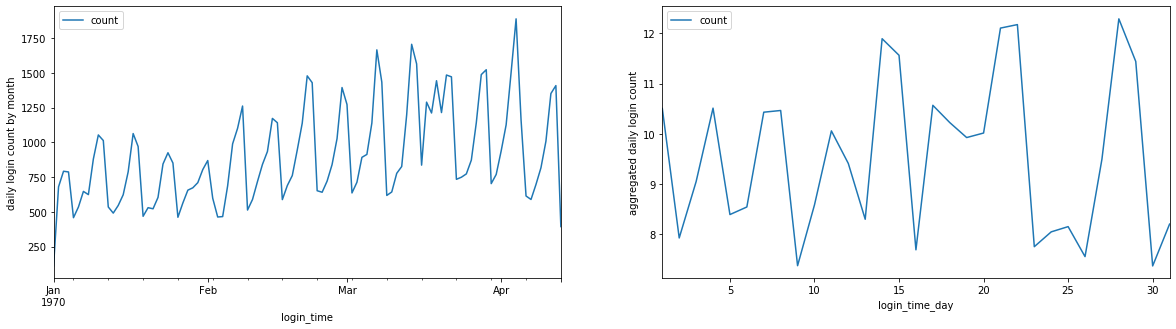

In [11]:
daily = df.resample('D').sum()
by_day = df.groupby(df.index.day).mean()

fig, axes = plt.subplots(1,2, figsize=(20, 5))
daily.plot(ax=axes[0])
axes[0].set_xlabel('login_time')
axes[0].set_ylabel('daily login count by month')
by_day.plot(ax=axes[1])
axes[1].set_xlabel('login_time_day')
_= axes[1].set_ylabel('aggregated daily login count')

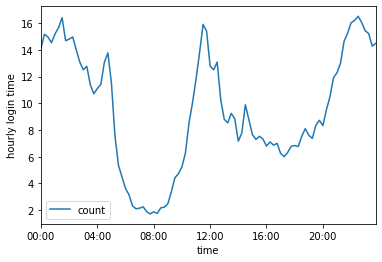

In [12]:
by_time = df.groupby(df.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks = hourly_ticks)
_ = plt.ylabel('hourly login time')

## Analysis
First of all, data was not ordered in time sequence, so I did sorting for data. Also, data is not complete in April. The data was only available until 1970-04-13 18:45:00. Based on several plots above, data shows repeated pattern over months. This shows user logins happen more every weekend other than typical weekdays. Hourly login time indicates a meaningful pattern since this data was collected in a particular geographic location. We can conclude users login a lot in the evening and also around midnight. As morning comes, it decreases. It keep increasing after morning until noon.

# Part 2 - Experiment and metrics design

1. If there are more driver partners available in both cities, we would have more number of driver partners passing a two-way toll. Since Gotham is most active at night, and Metropolis is most active during the day, it would be really inefficient if driver partners are exclusive to eacy city. Some in Gotham will have less work during the day, and others in Metropolis will have less work at night. This will be waste of human resource. Therfore, if driver partners more tend to drive back and forth between city especially on weekdays, we can save more human resources. The key measure of success will be average number of driver partners passing a two-way toll over weekdays. 

2. We need to conduct A/B testing here. A null hypothesis will be the number of driver partners passing a two-way toll is identically distributed regardless of toll cost reimbursement. We can measure the number of driver partners passing a two-way tall for month for each case. One is before reimbursement, the other is after doing reimbursement. From our data, we need to calculate empircal average difference between two cases. However to verify the signifcance of data observation, I will generate permutation replicates (average difference between two cases). In bootstrap permutation, scramble the whole data, ramdomly split the data into two cases. We can simulate this bootstrap permutation over and over (e.g. 10000 times) to have many average difference replicates. We can measure p-value from checking how many replicates are larger than our empiral average difference. If we got really low p-value (e.g. less than 0.05), we can reject our null hypothesis which means toll reimbursement have a significance effect statistically. If it is not the case (p >= 0.05), our null hypothesis is true, so we cannot verify proposed change (toll reimbursement) affected the number of driver partners passing a two-way toll. Even though p-value is really low, city operation needs to compare their reimbursement cost to driver partners with their benefit in terms of human resource. Average difference could be low even if our experiment is statiscally significant, which means reimbursement cost is more. In this case the proposed change should not be adopted.  

# Part 3 - Predictive modeling

## 1. Exploratory data analysis

In [13]:
import json
js = json.load(open('ultimate_data_challenge.json'))
df = pd.DataFrame(js)

In [14]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [16]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
city                      49992 non-null object
trips_in_first_30_days    49992 non-null int64
signup_date               49992 non-null object
avg_rating_of_driver      41873 non-null float64
avg_surge                 49992 non-null float64
last_trip_date            49992 non-null object
phone                     49596 non-null object
surge_pct                 49992 non-null float64
ultimate_black_user       49992 non-null bool
weekday_pct               49992 non-null float64
avg_dist                  49992 non-null float64
avg_rating_by_driver      49791 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


There exist NaN values in three columns, "avg_rating_of_driver", "phone", "avg_rating_by_driver". We have only small amount of NaN values in "Phone" and "avg_rating_by_driver columns, so we can drop corresponding observations here. However, there are many NaN values "avg_rating_of_driver" (almost 20% out of total), so we cannot simply drop them. Instead, I will fill mean values to NaN for this column. Otherwise, we might lose other valuable observation features.

In [17]:
mean_avg_rating_of_driver = df['avg_rating_of_driver'].mean()
df["avg_rating_of_driver"] = df["avg_rating_of_driver"].fillna(mean_avg_rating_of_driver)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
city                      49992 non-null object
trips_in_first_30_days    49992 non-null int64
signup_date               49992 non-null object
avg_rating_of_driver      49992 non-null float64
avg_surge                 49992 non-null float64
last_trip_date            49992 non-null object
phone                     49596 non-null object
surge_pct                 49992 non-null float64
ultimate_black_user       49992 non-null bool
weekday_pct               49992 non-null float64
avg_dist                  49992 non-null float64
avg_rating_by_driver      49791 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [18]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49398 entries, 0 to 49999
Data columns (total 12 columns):
city                      49398 non-null object
trips_in_first_30_days    49398 non-null int64
signup_date               49398 non-null object
avg_rating_of_driver      49398 non-null float64
avg_surge                 49398 non-null float64
last_trip_date            49398 non-null object
phone                     49398 non-null object
surge_pct                 49398 non-null float64
ultimate_black_user       49398 non-null bool
weekday_pct               49398 non-null float64
avg_dist                  49398 non-null float64
avg_rating_by_driver      49398 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


convert to datetime type and check user's last trip is within 30 days from the latest trip in observations.
'retained' column will be our label for users (True or False)

In [19]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
max_last_trip_date = np.max(df.last_trip_date)
print("the latest trip: ", max_last_trip_date)
df['retained'] = (max_last_trip_date - df.last_trip_date).dt.days
df.head()

the latest trip:  2014-07-01 00:00:00


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,14
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,57
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,175
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,108


In [20]:
df['retained'] = df['retained'] <= 30
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


I have already used "last_trip_date" feature to generate the label for observation, so this feature should not be included when building a model.

In [21]:
df = df.drop(['last_trip_date'], axis=1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,False


In [22]:
retained_fraction = np.sum(df.retained)/len(df)
print("the fraction of users who are retained: {:.2f}".format(retained_fraction))

the fraction of users who are retained: 0.38


## 2. build a predictive model

explore categorical values 

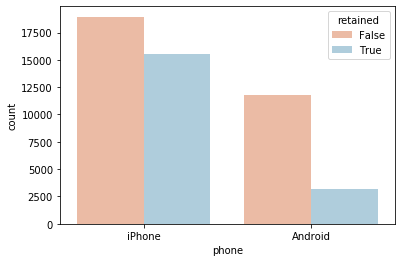

In [23]:
plt.figure()
sns.countplot(x='phone', hue='retained', data=df, palette='RdBu')
plt.show()

Phone feature could affect our retained label here. iPhone users tend to be more retained based on above.

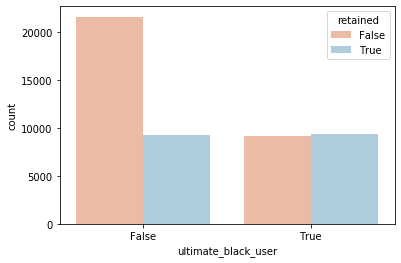

In [24]:
plt.figure()
sns.countplot(x='ultimate_black_user', hue='retained', data=df, palette='RdBu')
plt.show()

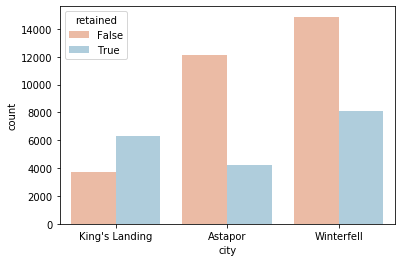

In [25]:
plt.figure()
sns.countplot(x='city', hue='retained', data=df, palette='RdBu')
plt.show()

All categorical features look like they cannot be ignored for our feature selection, so one-hot-encode categorical values, and scale continuous ones. Also, I will cut signup_date variables into only day variable(because all data in signup_date is in 2014, January).

In [26]:
from sklearn.preprocessing import StandardScaler

df.signup_date = pd.to_datetime(df.signup_date)
df.signup_date = df.signup_date.dt.day
columns_to_scale = ['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df = pd.get_dummies(df, drop_first=True)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_iPhone
0,0.451549,0.966243,0.174289,0.114790,0.329380,True,-0.397550,-0.375729,0.496884,True,1,0,1
1,-0.601249,1.422999,0.705910,-0.337652,-0.444830,False,-0.294901,0.439905,0.496884,False,0,0,0
2,0.188350,-1.203350,-0.534538,-0.337652,-0.444830,False,1.055740,-0.891054,0.496884,False,0,0,1
3,1.767548,-0.746593,-0.002918,0.295768,0.560637,True,0.515484,-0.608514,0.273239,True,1,0,1
4,3.083546,1.194621,-0.357331,0.521989,0.148396,False,0.580314,-0.471686,0.273239,False,0,1,0


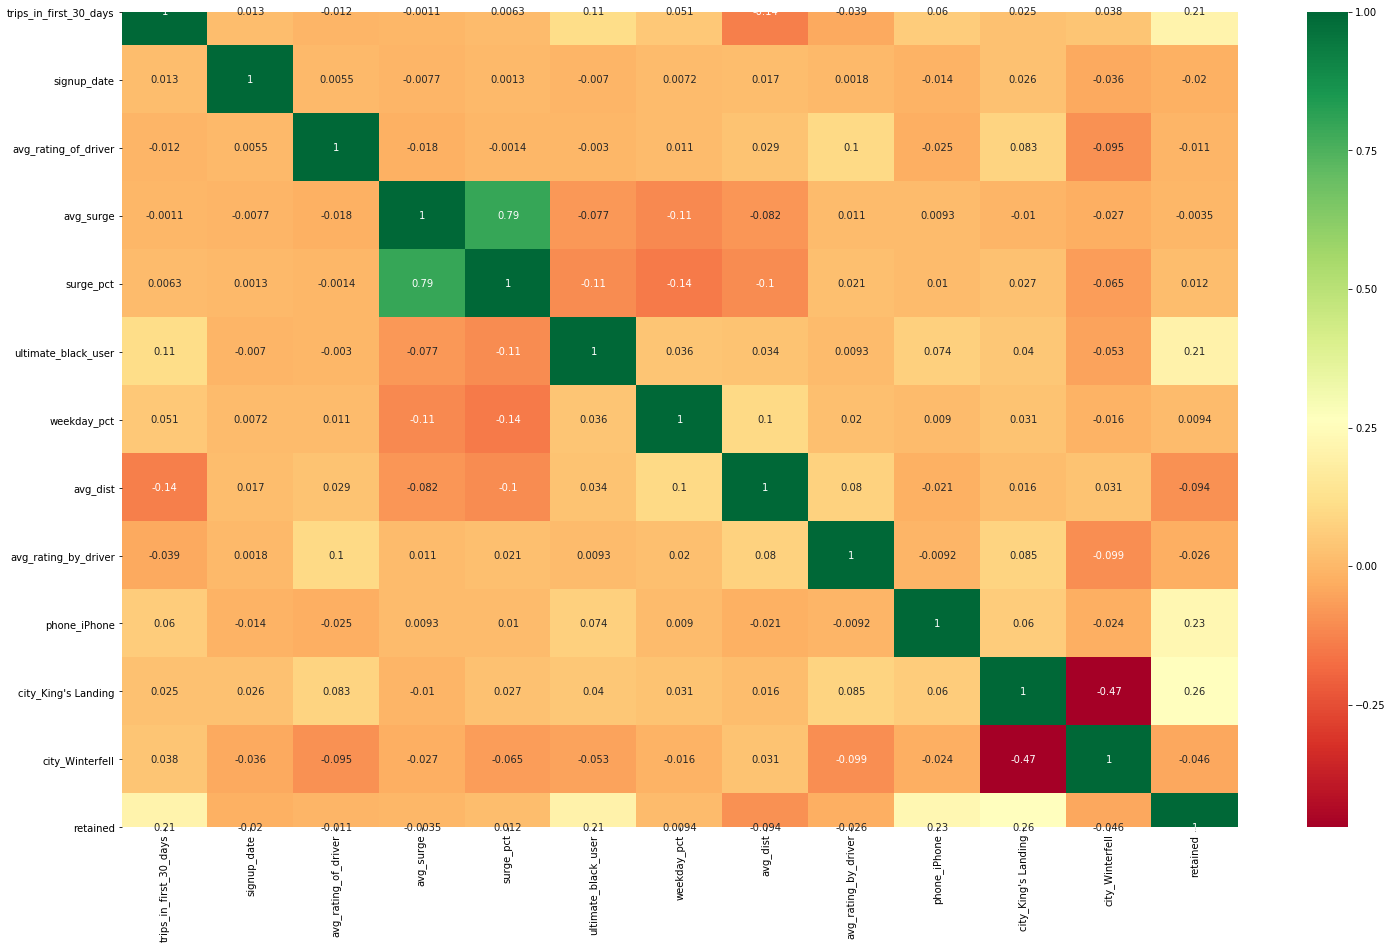

In [27]:
cols = list(df.columns.values)
cols[-1], cols[-4] = cols[-4], cols[-1]
df = df[cols]
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,15))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

C:\Users\bluep\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


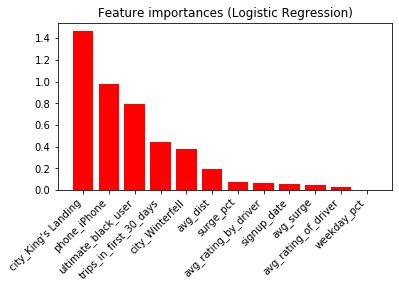

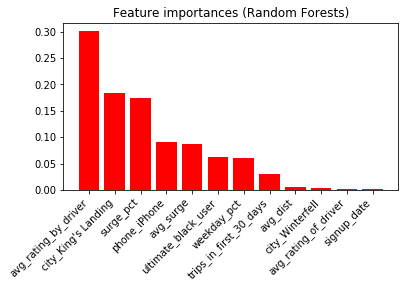

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
clf = LogisticRegressionCV(max_iter=3000)
clf.fit(X, y)
coefs = np.abs(clf.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(12), coefs[indices[:12]],
       color="r", align="center")
plt.xticks(range(12), df.columns[indices[:12]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

clf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=400, max_depth=6, max_features=6)
clf.fit(X, y)
coefs = clf.feature_importances_
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Random Forests)")
plt.bar(range(12), coefs[indices[:12]],
       color="r", align="center")
plt.xticks(range(12), df.columns[indices[:12]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

plt.ion(); plt.show()

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
gs = GridSearchCV(LogisticRegression(solver='liblinear', penalty='l1'), param_grid={"C":[0.001, 0.01, 0.1, 1, 10, 100]}, cv=5)
gs.fit(X_train, y_train)
print("Best Params:", gs.best_params_)
best = gs.best_estimator_
y_pred = best.predict(X_test)
print("L1-Logistic Regression accuracy score:", accuracy_score(y_test, y_pred))
print("confusion matrix:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Params: {'C': 0.01}
L1-Logistic Regression accuracy score: 0.7179149797570851
confusion matrix: [[5321  832]
 [1955 1772]]
              precision    recall  f1-score   support

       False       0.73      0.86      0.79      6153
        True       0.68      0.48      0.56      3727

    accuracy                           0.72      9880
   macro avg       0.71      0.67      0.68      9880
weighted avg       0.71      0.72      0.70      9880



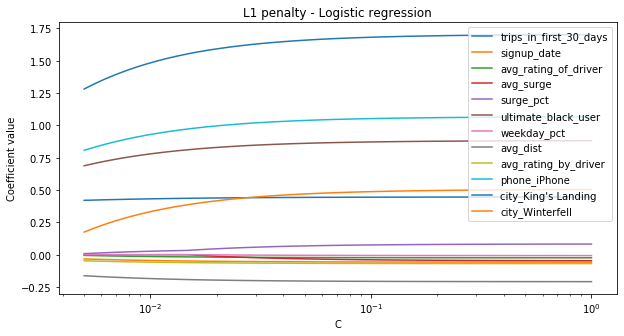

In [33]:
cs = np.logspace(-2.3, 0, 50)
coefs = []
for c in cs:
    clf = LogisticRegression(solver='liblinear',C=c,penalty='l1')
    # clf = LinearSVC(C=c,penalty='l1', loss='squared_hinge', dual=False, tol=1e-3)
    
    clf.fit(X_train, y_train)
    coefs.append(list(clf.coef_[0]))
    
coefs = np.array(coefs)
plt.figure(figsize=(10,5))
for i,col in enumerate(range(12)):
    plt.plot(cs,coefs[:,col])
plt.xscale('log')
plt.title('L1 penalty - Logistic regression')
plt.xlabel('C')
plt.ylabel('Coefficient value')
plt.legend(df.columns.values[:-1], loc='upper right')
plt.show()


In [34]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier('most_frequent')
clf.fit(X_train, y_train)
print("Dummy Classifier Prediction accuracy: %f"
      % clf.score(X_test, y_test))

Dummy Classifier Prediction accuracy: 0.622773


In [35]:
rf = RandomForestClassifier(n_estimators=500, random_state=0).fit(X_train, y_train)

print("random forest score: %f" % rf.score(X_test, y_test))

random forest score: 0.775607


In [36]:
from sklearn.svm import SVC
svc_classifier = SVC(kernel='rbf')
svc_classifier.fit(X_train, y_train)
y_pred = svc_classifier.predict(X_test)
print("linear SVM accuracy score:", accuracy_score(y_test, y_pred))
print("confusion matrix:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\bluep\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


linear SVM accuracy score: 0.7758097165991903
confusion matrix: [[5413  740]
 [1475 2252]]
              precision    recall  f1-score   support

       False       0.79      0.88      0.83      6153
        True       0.75      0.60      0.67      3727

    accuracy                           0.78      9880
   macro avg       0.77      0.74      0.75      9880
weighted avg       0.77      0.78      0.77      9880



I tested logistic regression, random forest, and support vector machine. Generally, it looks random forest and support vector machine perform better than logistic regression